<a href="https://colab.research.google.com/github/Sabarna07-tech/Drozy_CNN-LSTM-GRU/blob/main/Drozy_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'drowsy-mat-eeg:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5699580%2F9392004%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240929%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240929T174949Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6534a8970259b640e673d5425b20b5967da6dd14450755edd26cdb935ba6a570e6e71b164388817a30ad6e40a4d7d82bf0a19c0c06929d20a2ee5f8dbdb18c95adf3864325e6608f3470ab4ba6ccf1d79d7b3da9b13c4a9956ad17d9ed2a3d827845ef92eff285bd788bb222acb511ed7b54cb8fd0c7e68935b032b4dccd1427d371c197d2d10abff09b3c3947d9b25351741a830677303080f8c2f3b0b1cf0ce0ea382b7a3ca2cbeddfbaf05c3211b05baf3ac0c389c3746c56a54a94a9a383d24a4bf19c6583e6c9be294a35825aecbb24e0881b3e3f17ad13c1eb95d13cff093cee6ac87780fce95e3ae6db1772e97dcac4f00026ca724276c3e6bd62a3f2,sleepy-driver-eeg-brainwave:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5770370%2F9485502%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240929%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240929T174949Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0bbb25302834120931956a5cedeb0dc214b6a0d280fa0d18cceb88fc4adc69cf25303c073c54affed8a9585aaec317b01f59c3d22f15b8a1338a230f22bc0129ce3be69a8c656ee58f9d2b810920d00378f7e200375f55af0ad532a9d7be296ed1860912d534b3309e78fd4d9afca8aac8fc32efbd061d5c298cf85569ca6f78c376483b501861f89615ed8ee019d59604514510e78ff8e20acca70b68a5d53dafc541190e7482ea076e8e870b6e0eef7291c7048f70e0cddad10d3857f7401d00ca672d3ef5aa1146eee9dc559906e9493d138288c95134f4ab1e5d7771e6448b1865a5fb0380ea9d1d10d5c83aa3d3ab7d5efc0ed14f900d9f37ce4c823d79'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 180884754 bytes downloaded
Downloaded and uncompressed: drowsy-mat-eeg
[==================================================] 93280 bytes downloaded
Downloaded and uncompressed: sleepy-driver-eeg-brainwave
Data source import complete.


In [2]:
## Data handling
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

## Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import missingno as msno # missing values visualization

## Stats
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import norm

## Preprocessing
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
import time

## Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/kaggle/input/sleepy-driver-eeg-brainwave/acquiredDataset.csv')
data.head()

,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,classification
0,26,34,960462,277180,26575,27356,26575,13056,9126,2683,0
1,29,54,39145,28225,20172,39551,20172,9933,5237,4750,0
2,40,48,75410,43144,8601,13564,8601,11663,2515,3251,0
3,66,47,16057,41211,2534,34254,2534,27663,11396,2825,0
4,81,67,10304,47239,33158,47349,33158,16328,5298,5471,0


In [4]:
print(f'Data size: {data.shape[0]} rows and {data.shape[1]} columns')

Data size: 3735 rows and 11 columns


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3735 entries, 0 to 3734
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   attention       3735 non-null   int64
 1   meditation      3735 non-null   int64
 2   delta           3735 non-null   int64
 3   theta           3735 non-null   int64
 4   lowAlpha        3735 non-null   int64
 5   highAlpha       3735 non-null   int64
 6   lowBeta         3735 non-null   int64
 7   highBeta        3735 non-null   int64
 8   lowGamma        3735 non-null   int64
 9   highGamma       3735 non-null   int64
 10  classification  3735 non-null   int64
dtypes: int64(11)
memory usage: 321.1 KB


In [6]:
data.isna().sum()

,0
attention,0
meditation,0
delta,0
theta,0
lowAlpha,0
highAlpha,0
lowBeta,0
highBeta,0
lowGamma,0
highGamma,0


<Axes: >

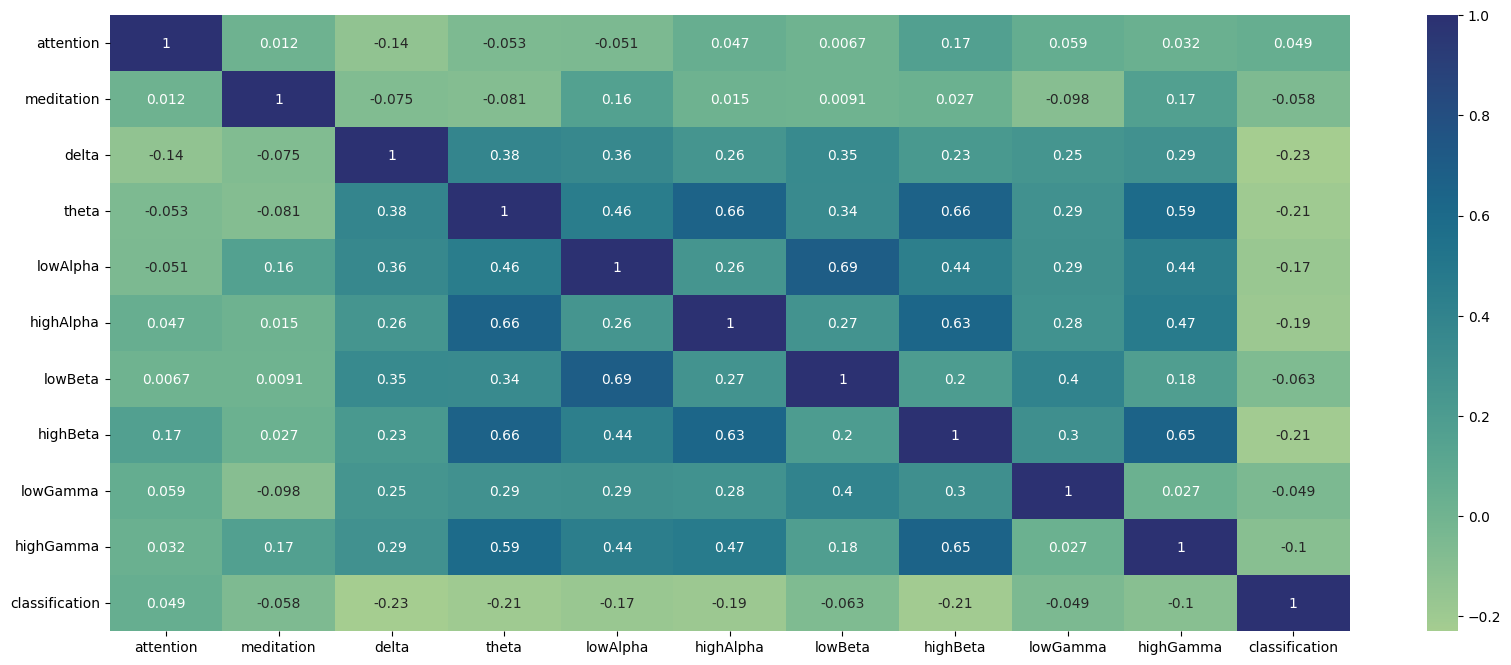

In [7]:
plt.figure(figsize=(20, 8))
sns.heatmap(data.corr(), cmap="crest", annot=True)


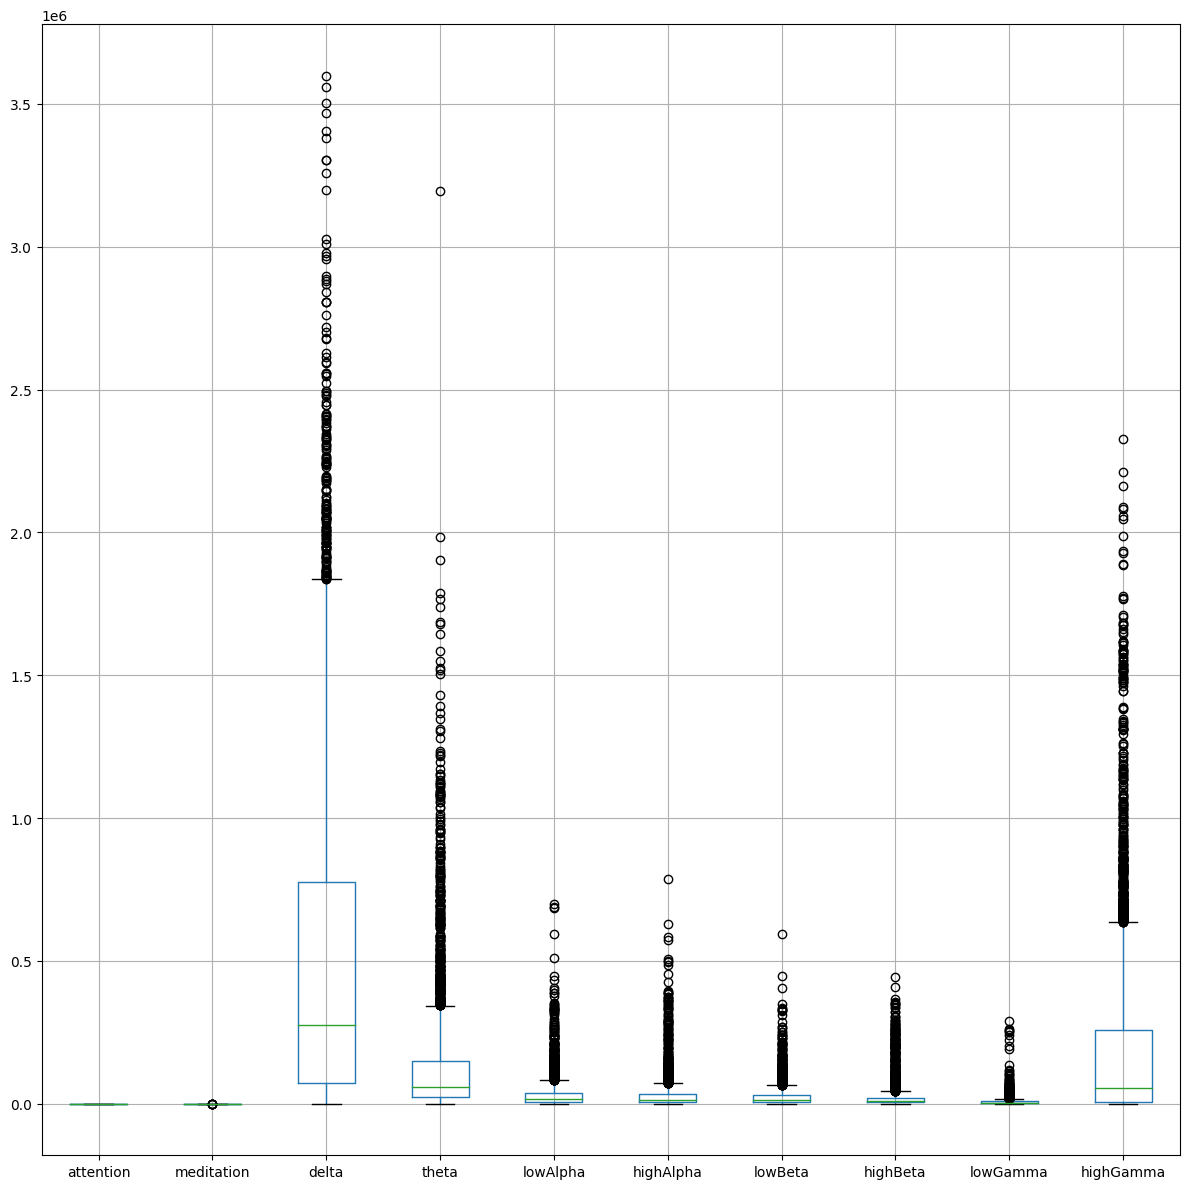

In [8]:
df = data.drop(columns='classification')
plt.figure(figsize=(12,12))
df.boxplot()
plt.tight_layout()

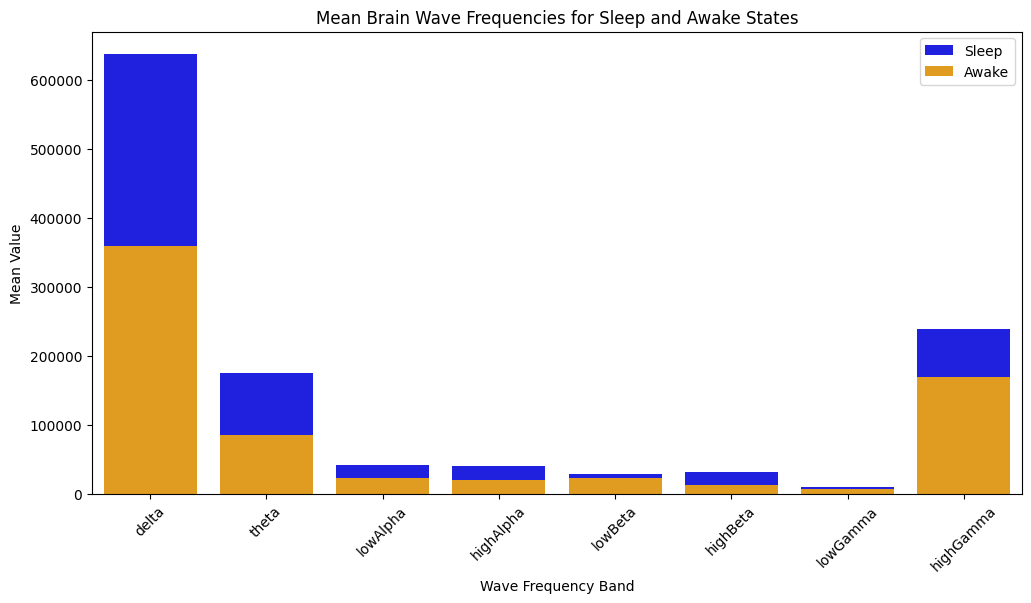

In [9]:
means_by_state = data.groupby('classification')[['delta', 'theta', 'lowAlpha', 'highAlpha',
                                                 'lowBeta', 'highBeta', 'lowGamma', 'highGamma',]].mean()


means_by_state = means_by_state.T.reset_index()

means_by_state.columns = ['Wave Frequency Band', 'Sleep', 'Awake']
bands_order = ['delta', 'theta', 'lowAlpha', 'highAlpha',
               'lowBeta', 'highBeta', 'lowGamma', 'highGamma']

means_by_state = means_by_state[means_by_state['Wave Frequency Band'].isin(bands_order)]

plt.figure(figsize=(12, 6))
sns.barplot(x='Wave Frequency Band', y='Sleep', data=means_by_state, label='Sleep', color='blue')

# Plot 'Awake' with another color
sns.barplot(x='Wave Frequency Band', y='Awake', data=means_by_state, label='Awake', color='orange')

plt.xlabel('Wave Frequency Band')
plt.ylabel('Mean Value')
plt.title('Mean Brain Wave Frequencies for Sleep and Awake States')
plt.legend()

# Show the plot
plt.xticks(rotation=45)
plt.show()

<Axes: >

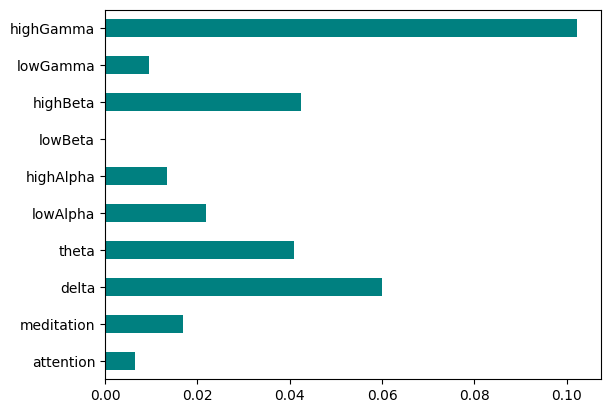

In [10]:
from sklearn.feature_selection import mutual_info_classif
x = df
y = data['classification']
importance = mutual_info_classif(x,y)
feat_importance = pd.Series(importance, index = x.columns)
feat_importance.plot(kind="barh",color="teal")

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model
from keras import regularizers
from keras.models import Model

In [12]:
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
from sklearn.exceptions import FitFailedWarning
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.simplefilter(action='ignore', category=UserWarning)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
from sklearn.feature_selection import SelectKBest, chi2

# Features (X) and Target (y)
X = df  # All features except 'classification'
y = data['classification']  # Target is 'classification'

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle =True)

In [15]:
# Apply the Chi-Squared test
chi_selector = SelectKBest(chi2, k='all')  # Set k to 'all' to get scores for all features
X_kbest = chi_selector.fit_transform(X, y)

In [16]:
# Get the Chi-Squared scores for each feature
chi_scores = chi_selector.scores_

# Combine scores with feature names
chi_scores_df = pd.DataFrame({'feature': X.columns, 'score': chi_scores})

# Sort the features by their Chi-Squared scores
chi_scores_df = chi_scores_df.sort_values(by='score', ascending=False)

# Display the scores
print(chi_scores_df)


      feature         score
2       delta 136881405.547
3       theta  54824710.056
9   highGamma  20960834.352
7    highBeta  14113547.557
5   highAlpha  12353187.636
4    lowAlpha   9221223.241
6     lowBeta    806759.170
8    lowGamma    266967.686
0   attention        90.025
1  meditation        79.718


In [17]:
# Apply the Chi-Squared test
chi_selector = SelectKBest(chi2, k='all')  # Set k to 'all' to get scores for all features
X_kbest = chi_selector.fit_transform(X, y)

# Get the Chi-Squared scores for each feature
chi_scores = chi_selector.scores_

# Combine the scores with feature names in a DataFrame
chi_scores_df = pd.DataFrame({'feature': X.columns, 'score': chi_scores})

# Sort the features by their Chi-Squared scores and reset the index
chi_scores_df = chi_scores_df.sort_values(by='score', ascending=False).reset_index(drop=True)

# Select the top k features (e.g., 8 most relevant features)
selected_features = chi_scores_df['feature'].head(8).tolist()
print(f'Selected Features: {selected_features}')

Selected Features: ['delta', 'theta', 'highGamma', 'highBeta', 'highAlpha', 'lowAlpha', 'lowBeta', 'lowGamma']


In [18]:
from sklearn.model_selection import train_test_split
# Split the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Further split the training data into train (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

# Now you can proceed with training your models on X_train, y_train and validating them on X_val, y_val

In [19]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (2614, 8)
X_val shape: (374, 8)
X_test shape: (747, 8)


In [20]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [21]:
# Reshape input data to have a larger second dimension
# Reshape X_train, X_val, X_test based on the number of features instead of 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Assuming each sample has 8 features
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [22]:
def cnn_lstm_gru_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=1),

        Conv1D(filters=64, kernel_size=2, activation='relu'),
        MaxPooling1D(pool_size=1),

        LSTM(64, return_sequences=True),
        GRU(64, return_sequences=False),

        Flatten(),
        Dense(128, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
        Dropout(0.6),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [23]:
input_shape = (X_train.shape[1], 1)  # Ensure correct shape
num_classes = 2  # Update according to your classification
model = cnn_lstm_gru_model(input_shape, num_classes)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 7, 32)               │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 6, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 6, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,818 (276.63 KB)

 Trainable params: 70,818 (276.63 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# prompt: # Build and compile the model first
# input_shape = (X_train.shape[1], 1)  # Assuming 1 feature per time step
# num_classes = 2  # For binary classification
# model = cnn_lstm_gru_model(input_shape, num_classes)
# # Train the model to ensure it's built
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)
# enable earlystopping and whatever is necessary for accur

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# Build and compile the model first
input_shape = (X_train.shape[1], 1)  # Assuming 1 feature per time step
num_classes = 2  # For binary classification
model = cnn_lstm_gru_model(input_shape, num_classes)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])


Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5528 - loss: 1.4980 - val_accuracy: 0.5508 - val_loss: 1.4071
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5793 - loss: 1.3734 - val_accuracy: 0.5508 - val_loss: 1.3023
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5467 - loss: 1.2859 - val_accuracy: 0.5695 - val_loss: 1.2163
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5919 - loss: 1.1971 - val_accuracy: 0.6150 - val_loss: 1.1427
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6047 - loss: 1.1237 - val_accuracy: 0.6203 - val_loss: 1.0779
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6190 - loss: 1.0642 - val_accuracy: 0.6070 - val_loss: 1.0202
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6131 - loss: 1.0059 - val_accuracy: 0.6096 - val_loss: 0.9693
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6088 - loss: 0.9641 - val_accuracy: 0.6176 - 

In [26]:
model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


array([[0.8824814 , 0.11751863],
       [0.85237   , 0.14762993],
       [0.39101562, 0.6089844 ],
       ...,
       [0.36604762, 0.63395244],
       [0.81092674, 0.18907325],
       [0.615842  , 0.38415802]], dtype=float32)

In [27]:

_ = model.evaluate(X_test, y_test)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7367 - loss: 0.5205


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
# from sklearn.base import clone  # Remove unnecessary import

# Extract weights from the CNN-LSTM-GRU model
weights = model.get_weights()

# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the Random Forest model normally
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Make predictions using the RF model
y_pred_rf = rf_model.predict(X_test.reshape(X_test.shape[0], -1))

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

# Create a wrapper for the Keras model to make it compatible with VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
    def fit(self, X, y):
        self.model.fit(X.reshape(X.shape[0], X.shape[1], 1), y)  # Reshape X for Keras
        return self
    def predict(self, X):
        return self.model.predict(X.reshape(X.shape[0], X.shape[1], 1)).argmax(axis=1)  # Reshape X and get class labels


# Instead of cloning, use tf.keras.models.clone_model to create a copy of the Keras model
from tensorflow.keras.models import clone_model
wrapped_keras_model = KerasClassifierWrapper(clone_model(model)) # Create a copy using tf.keras.models.clone_model

# Set weights for the cloned model if necessary
wrapped_keras_model.model.set_weights(weights)


Random Forest Accuracy: 0.7764390896921017


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
# from sklearn.base import clone  # Remove unnecessary import

# Extract weights from the CNN-LSTM-GRU model
weights = model.get_weights()

# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the Random Forest model normally
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Make predictions using the RF model
y_pred_rf = rf_model.predict(X_test.reshape(X_test.shape[0], -1))

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

# Create a wrapper for the Keras model to make it compatible with VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
    def fit(self, X, y):
        # Compile the model before fitting
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # Replace with your desired compilation settings
        self.model.fit(X.reshape(X.shape[0], X.shape[1], 1), y)  # Reshape X for Keras
        return self
    def predict(self, X):
        return self.model.predict(X.reshape(X.shape[0], X.shape[1], 1)).argmax(axis=1)  # Reshape X and get class labels


# Instead of cloning, use tf.keras.models.clone_model to create a copy of the Keras model
from tensorflow.keras.models import clone_model
wrapped_keras_model = KerasClassifierWrapper(clone_model(model)) # Create a copy using tf.keras.models.clone_model

# Set weights for the cloned model if necessary
wrapped_keras_model.model.set_weights(weights)


Random Forest Accuracy: 0.7764390896921017


In [36]:
from keras.models import Model  # Import Model from keras.models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.models import clone_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_selection import SelectKBest, chi2
from tensorflow.keras import regularizers

# Assuming you have already trained your model (model) and have X_train, X_val, X_test, y_train, y_val, y_test

# Call the model once to define the input shape
# This can be done with a small dummy input
# or by using any of your existing data (X_train, X_val, or X_test)
_ = model(X_train[:1]) # Call the model once with a small sample
#Alternatively: _ = model.predict(X_train[:1])

# Now you can access model.input and model.layers
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)
X_train_features = feature_extractor.predict(X_train)
X_val_features = feature_extractor.predict(X_val)
X_test_features = feature_extractor.predict(X_test)

# Create a Random Forest model using the extracted features
rf_model_extracted = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_extracted.fit(X_train_features, y_train)

# Make predictions using the RF model with extracted features
y_pred_rf_extracted = rf_model_extracted.predict(X_test_features)

# Evaluate the Random Forest model with extracted features
accuracy_rf_extracted = accuracy_score(y_test, y_pred_rf_extracted)
print("Random Forest Accuracy (with extracted features):", accuracy_rf_extracted)





ValueError: The layer sequential_2 has never been called and thus has no defined input.

In [28]:
from keras.models import Model

# Now extract features from the second-to-last layer
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

# Get the extracted features for the train, validation, and test sets
X_train_features = feature_extractor.predict(X_train)
X_val_features = feature_extractor.predict(X_val)
X_test_features = feature_extractor.predict(X_test)


ValueError: The layer sequential_2 has never been called and thus has no defined input.

In [ ]:
# Import necessary callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
train_start_time = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)
train_end_time = time.time()

# # Evaluate the model on the test data
# test_start_time = time.time()
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)
# test_end_time = time.time()

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# # Calculate and print training and testing times
# train_time = train_end_time - train_start_time
# test_time = test_end_time - test_start_time
# print(f"Training time: {train_time:.2f} seconds")
# print(f"Testing time: {test_time:.2f} seconds")

Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7248 - loss: 0.5371 - val_accuracy: 0.7193 - val_loss: 0.5398
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7371 - loss: 0.5283 - val_accuracy: 0.7166 - val_loss: 0.5596
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7320 - loss: 0.5378 - val_accuracy: 0.7246 - val_loss: 0.5438
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7356 - loss: 0.5125 - val_accuracy: 0.7219 - val_loss: 0.5379
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7267 - loss: 0.5281 - val_accuracy: 0.7193 - val_loss: 0.5441
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7368 - loss: 0.5153 - val_accuracy: 0.7299 - val_loss: 0.5417
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7364 - loss: 0.5169 - val_accuracy: 0.7273 - val_loss: 0.5353
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7215 - loss: 0.5309 - val_accuracy: 0.7166 - val_loss:

In [ ]:
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)  # Get features from the second last layer

# Get features from the training, validation, and test sets
X_train_features = feature_extractor.predict(X_train)
X_val_features = feature_extractor.predict(X_val)
X_test_features = feature_extractor.predict(X_test)

ValueError: The layer sequential has never been called and thus has no defined input.

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 200], # Number of trees in the forest
    'max_depth': [None,10], # Maximum depth of individual trees, None means indefinite
    'min_samples_split': [2, 5], # minimum number of samples required to split an internal node in a decision tree.
    'min_samples_leaf': [1, 2], # minimum number of samples allowed at a leaf node
    'max_features': ['sqrt'], #  number of features considered at each split in a decision tree.
}

# Create a grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)
# Evaluate the model on the test set using the best hyperparameters
best_rf_classifier = grid_search.best_estimator_
test_accuracy = best_rf_classifier.score(X_test, y_test)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy: 0.7792649245804122
Test Accuracy: 78.41%


In [ ]:
# Define the CNN-LSTM-GRU model
def cnn_lstm_gru_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),

        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),

        LSTM(64, return_sequences=True),
        GRU(64, return_sequences=False),

        Flatten(),

        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 6, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 0, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 0, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,898 (284.76 KB)

 Trainable params: 72,898 (284.76 KB)

 Non-trainable params: 0 (0.00 B)

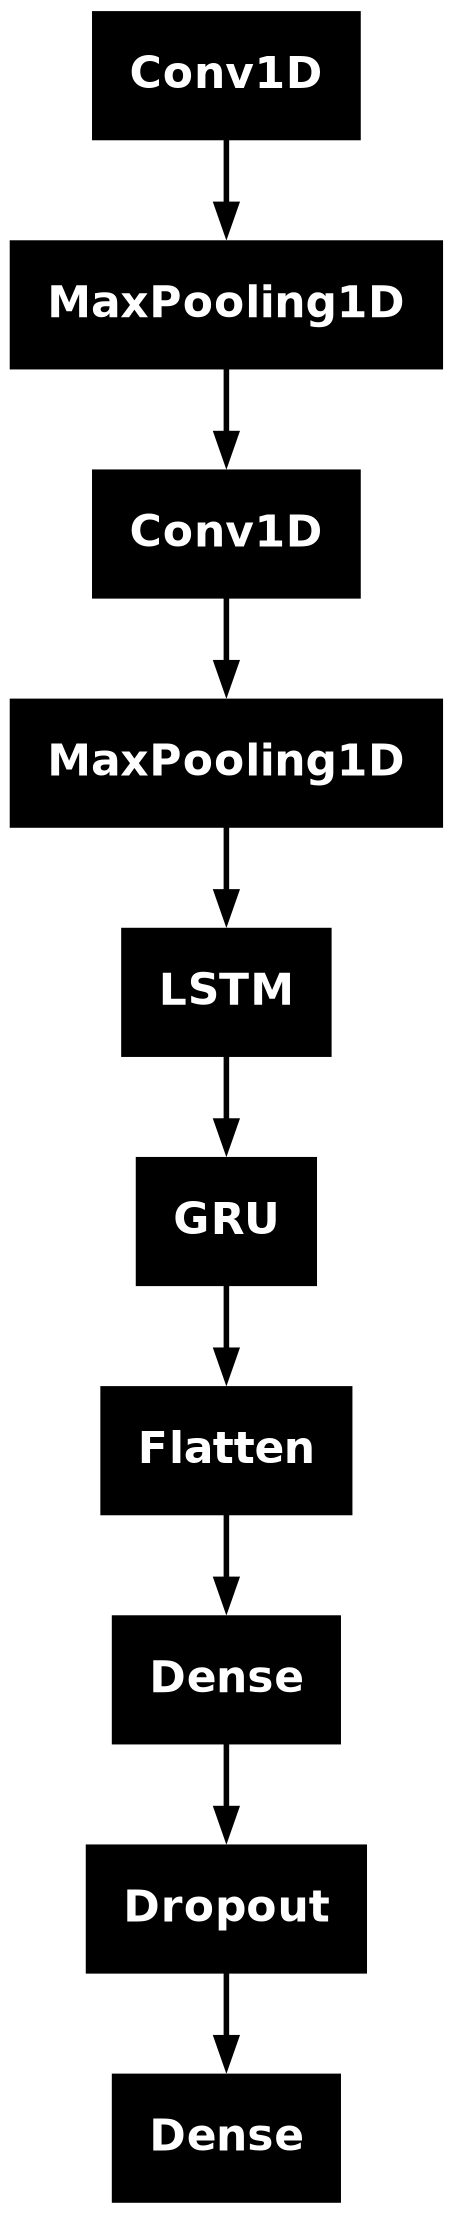

In [ ]:
input_shape = (X_train.shape[1], 1)
num_classes = 2
model = cnn_lstm_gru_model(input_shape, num_classes)
model.summary()
plot_model(model)